In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


C:\Users\srika\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'edu', 'use', 'new', 'may', 'could', 'say', 'get', 'go',
                   'know', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can', 'also', 'many', 
                   'do', 'be', 'also'])
print(len(stop_words))

205


In [3]:
stop_words = list(dict.fromkeys(stop_words))
len(stop_words)

198

In [4]:
df = pd.read_csv("data.csv", header=None)

In [5]:
len(df)

25650

In [6]:
df.columns = ["content", 'title', 'topic']
len(df)

25650

In [7]:
df = df.dropna(how='any',axis=0) 
len(df)

25204

In [8]:
df.iloc[1550].content

'Source: StockSnap.io used with permission. A study published in the September 2016 issue of the Journal of Health and Social Behavior looked at sexual behavior in more than 2000 men and women between the ages of 57 and 85 over a five-year period.'

In [9]:
from langdetect import detect
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [10]:
for index, row in df.iterrows():
    row['content'] = re.sub(r'[?|$|.|!_]',r'', row['content'])

In [11]:
df = df.dropna(how='any',axis=0) 
len(df)

25204

In [12]:
df.iloc[1551].content

'Despite the fondness certain corners of the internet and cable television have for mocking sexually vital senior women new research suggests that those who embrace their sexuality may be laughing all the way to longer healthier lives—though older…'

In [13]:
df['lang'] = ''
df.head()

,content,title,topic,lang
0,Teaching creationism in public schools has con...,On Evolution Biology Teachers Stray From Lesso...,General,
1,Collection of papers explores how and why the ...,Politics science and public attitudes: What we...,General,
2,Credit: NOAA A major new survey of US middle s...,How teachers are getting it wrong on climate c...,General,
3,Credit: NOAA A major new survey of US middle s...,How teachers are getting it wrong on climate c...,General,
4,Credit: NOAA A major new survey of US middle s...,How teachers are getting it wrong on climate c...,General,


In [14]:
for index, row in df.iterrows():
    try:
        row['lang'] = detect(row['content'])
    except:
        row['lang'] = 'en'
        

In [15]:
df = df.loc[df.lang=='en']
len(df)

22772

In [16]:
df = df.drop_duplicates()
len(df)

17637

In [17]:
scopus_subjects = ["Life Sciences", "Physical Sciences", "Social Sciences", "Psychology Medicine", "Health Sciences", "Biological Sciences", "Biochemistry", 
"Agricultural", "Molecular Biology", "Chemistry", "Genetics", "Neuroscience", "Physics", "Astronomy", "Materials Science", "Microbiology",
 "Immunology", "Environmental", "Pharmacology", "Business Management"]

In [18]:
# Convert to list
summaries = df.content.values.tolist()


In [19]:

# Remove Emails
summaries = [re.sub('\S*@\S*\s?', '', sent) for sent in summaries]

# Remove new line characters
summaries = [re.sub('\s+', ' ', sent) for sent in summaries]

# Remove distracting single quotes
summaries = [re.sub("\'", "", sent) for sent in summaries]

print(summaries[3:6])

['The group behind Kentucky’s Creation Museum hopes its new attraction — a 300-cubit-long Noah’s Ark — is the right blend of science and showmanship to bring millions to the literal word of the Bible', 'What will the incoming administration mean for science education in the United States In particular what impact might Betsy DeVos the pick for secretary of the Department of Education have on what is taught in our nation’s science classrooms A…', 'Linking the human nervous system to computers is providing unprecedented control of artificial limbs and restoring lost sensory function']


In [20]:
print(summaries[:1])

['Teaching creationism in public schools has consistently been ruled unconstitutional in federal courts but according to a national survey of more than 900 public high school biology teachers it continues to flourish in the nation’s']


In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(summaries))

print(data_words[:1])

[['teaching', 'creationism', 'in', 'public', 'schools', 'has', 'consistently', 'been', 'ruled', 'in', 'federal', 'courts', 'but', 'according', 'to', 'national', 'survey', 'of', 'more', 'than', 'public', 'high', 'school', 'biology', 'teachers', 'it', 'continues', 'to', 'flourish', 'in', 'the', 'nation']]


In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


In [24]:
data_words_nostops[1]

['collection',
 'papers',
 'explores',
 'public',
 'bends',
 'scientific',
 'findings',
 'fit',
 'beliefs']

# Using Bigram

In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\srika\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['teaching', 'creationism', 'in', 'public', 'schools', 'has', 'consistently', 'been', 'ruled', 'in', 'federal', 'courts', 'but', 'according', 'to', 'national', 'survey', 'of', 'more', 'than', 'public', 'high', 'school', 'biology', 'teachers', 'it', 'continues', 'to', 'flourish', 'in', 'the', 'nation']


In [26]:

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['teach', 'creationism', 'public', 'school', 'consistently', 'rule', 'federal', 'court', 'accord', 'national', 'survey', 'public', 'high', 'school', 'biology', 'teacher', 'continue', 'flourish', 'nation']


In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1)]]


In [28]:
len(corpus)

17637

In [29]:
print(data_lemmatized[1])

['collection', 'paper', 'explore', 'public', 'bend', 'scientific', 'finding', 'fit', 'belief']


In [30]:
print(len(id2word))

22902


In [32]:
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'C:/Users/srika/mallet-2.0.8/'

In [33]:
mallet_path = "C:/Users/srika/mallet-2.0.8/bin/mallet"

In [36]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=14, id2word=id2word, passes=2,  workers=4)

In [37]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

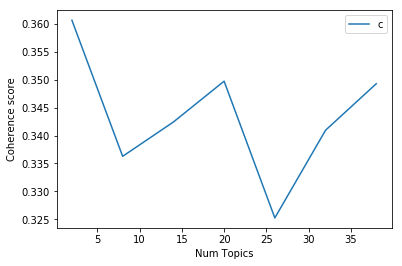

In [40]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
np.random.seed(123456)
num_topics = 14
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(id2word.keys()))

Wall time: 21.1 s


In [47]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"human" + 0.028*"cell" + 0.022*"scientist" + 0.020*"test" + '
  '0.016*"health" + 0.013*"virus" + 0.013*"blood" + 0.013*"way" + 0.012*"body" '
  '+ 0.012*"develop"'),
 (1,
  '0.035*"patient" + 0.029*"publish" + 0.020*"accord" + 0.019*"article" + '
  '0.018*"study" + 0.018*"online" + 0.013*"journal" + 0.013*"pain" + '
  '0.012*"doctor" + 0.011*"clinical"'),
 (2,
  '0.021*"conversation" + 0.015*"article" + 0.014*"publish" + 0.012*"age" + '
  '0.012*"next_article" + 0.011*"comment" + 0.011*"science" + '
  '0.011*"healthcare" + 0.011*"human" + 0.011*"american"'),
 (3,
  '0.018*"year" + 0.015*"news" + 0.012*"day" + 0.011*"good" + '
  '0.011*"university" + 0.011*"people" + 0.010*"share" + 0.009*"take" + '
  '0.008*"photo" + 0.008*"add"'),
 (4,
  '0.026*"not" + 0.021*"food" + 0.016*"do" + 0.016*"work" + 0.014*"eat" + '
  '0.011*"be" + 0.010*"back" + 0.010*"good" + 0.009*"add" + 0.009*"thing"'),
 (5,
  '0.042*"cancer" + 0.031*"researcher" + 0.026*"university" + 0.022*"disease" '


In [48]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3536038796424926


In [49]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3607
Num Topics = 8  has Coherence Value of 0.3363
Num Topics = 14  has Coherence Value of 0.3424
Num Topics = 20  has Coherence Value of 0.3497
Num Topics = 26  has Coherence Value of 0.3252
Num Topics = 32  has Coherence Value of 0.3409
Num Topics = 38  has Coherence Value of 0.3493


In [73]:
topics = [lda_model[corpus[i]] for i in range(len(df.content.values.tolist()))]

In [74]:
type(df.content.values.tolist())

list

In [75]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
topics_document_to_dataframe(topics[1], 10)

,0,1,2,3,4,5,6,7,8,9,12
0,NaN,NaN,0.478583,NaN,0.129247,NaN,NaN,0.26022,NaN,NaN,0.121009


In [76]:
topics[2][0]

(2, 0.54013824)

In [77]:
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics) for topics_document in topics])\
  .reset_index(drop=True).fillna(0)

In [78]:
document_topic.set_axis(["Topic "+ str(i) for i in range(14) ], axis='columns', inplace=True)
document_topic=document_topic.rename(columns = {'Topic 14':'dominant_topic'})
document_topic.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13
0,0.000000,0.0,0.080312,0.000000,0.000000,0.0,0.435914,0.00000,0.101481,0.000000,0.0,0.000000,0.289508,0.088082
1,0.000000,0.0,0.478583,0.000000,0.129247,0.0,0.000000,0.26022,0.000000,0.000000,0.0,0.000000,0.121009,0.000000
2,0.000000,0.0,0.540138,0.145717,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.104997,0.204182,0.000000
3,0.000000,0.0,0.089138,0.000000,0.129225,0.0,0.000000,0.00000,0.000000,0.057966,0.0,0.000000,0.000000,0.718447
4,0.468194,0.0,0.058299,0.000000,0.000000,0.0,0.177804,0.00000,0.000000,0.000000,0.0,0.000000,0.290479,0.000000


In [97]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics_st = document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics_st

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,dominant_topic
0,0,0,0.0803124,0,0,0,0.435914,0,0.101481,0,0,0,0.289508,0.0880821,6
1,0,0,0.478583,0,0.129247,0,0,0.26022,0,0,0,0,0.121009,0,2
2,0,0,0.540138,0.145717,0,0,0,0,0,0,0,0.104997,0.204182,0,2
3,0,0,0.0891375,0,0.129225,0,0,0,0,0.0579656,0,0,0,0.718447,13
4,0.468194,0,0.0582991,0,0,0,0.177804,0,0,0,0,0,0.290479,0,0
5,0.171622,0,0,0,0,0,0,0,0.819246,0,0,0,0,0,8
6,0,0.530471,0,0,0,0,0,0.0858736,0,0.375284,0,0,0,0,1
7,0,0,0,0.481963,0,0,0.374666,0,0,0.136105,0,0,0,0,3
8,0,0,0,0.0585025,0.600905,0,0,0,0.0745557,0.116075,0,0,0,0.14526,4
9,0,0,0.223442,0,0,0,0,0,0.763429,0,0,0,0,0,8


In [80]:
dominant_topic = np.argmax(document_topic.values, axis=1)
document_topic['dominant_topic'] = dominant_topic

In [81]:
df_topic_distribution = document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic_Num', 'Num_Documents']
df_topic_distribution

,Topic_Num,Num_Documents
0,11,2594
1,12,2021
2,5,1848
3,9,1429
4,3,1420
5,4,1171
6,0,1126
7,1,1086
8,8,1030
9,2,952


In [61]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.4359,"drug, science, institute, target, june, surger...","[teach, creationism, public, school, consisten..."
1,1,2.0,0.4787,"conversation, article, publish, age, next_arti...","[collection, paper, explore, public, bend, sci..."
2,2,2.0,0.5402,"conversation, article, publish, age, next_arti...","[credit, noaa, major, survey, middle, school, ..."
3,3,13.0,0.7186,"hour, time, people, memory, seem, night, zika_...","[group, kentucky, creation, museum, hope, attr..."
4,4,0.0,0.4682,"human, cell, scientist, test, health, virus, b...","[incoming, administration, mean, science, educ..."
5,5,8.0,0.8192,"ocean, water, earth, world, number, report, mo...","[link, human, nervous_system, computer, provid..."
6,6,1.0,0.5305,"patient, publish, accord, article, study, onli...","[researcher, turn, brain, wave, thought, word,..."
7,7,3.0,0.4819,"year, news, day, good, university, people, sha...","[march, physics, numerical, analysis, suggest,..."
8,8,4.0,0.6009,"not, food, do, work, eat, be, back, good, add,...","[raw, foodist, campaign, group, eager, return,..."
9,9,8.0,0.7634,"ocean, water, earth, world, number, report, mo...","[fundamental, belief, include, free, influence..."


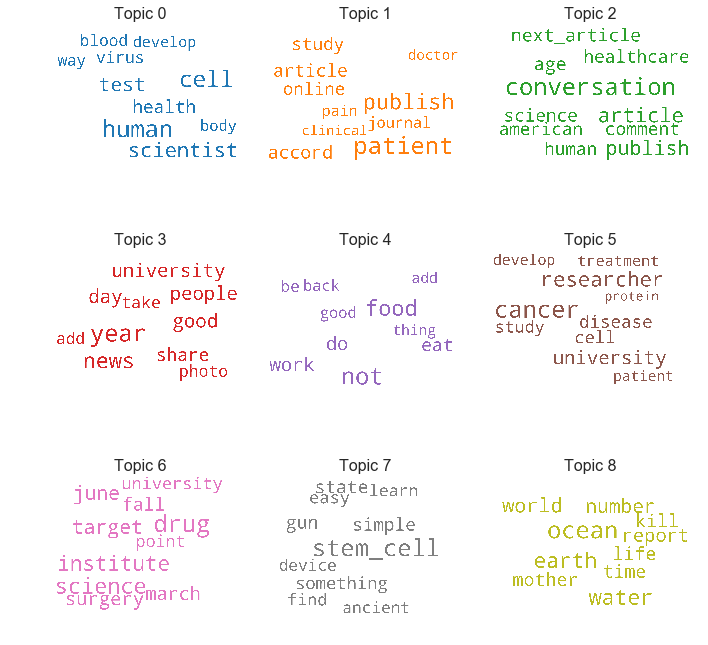

In [82]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_t = lda_model.show_topics(num_topics=14, formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_t[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

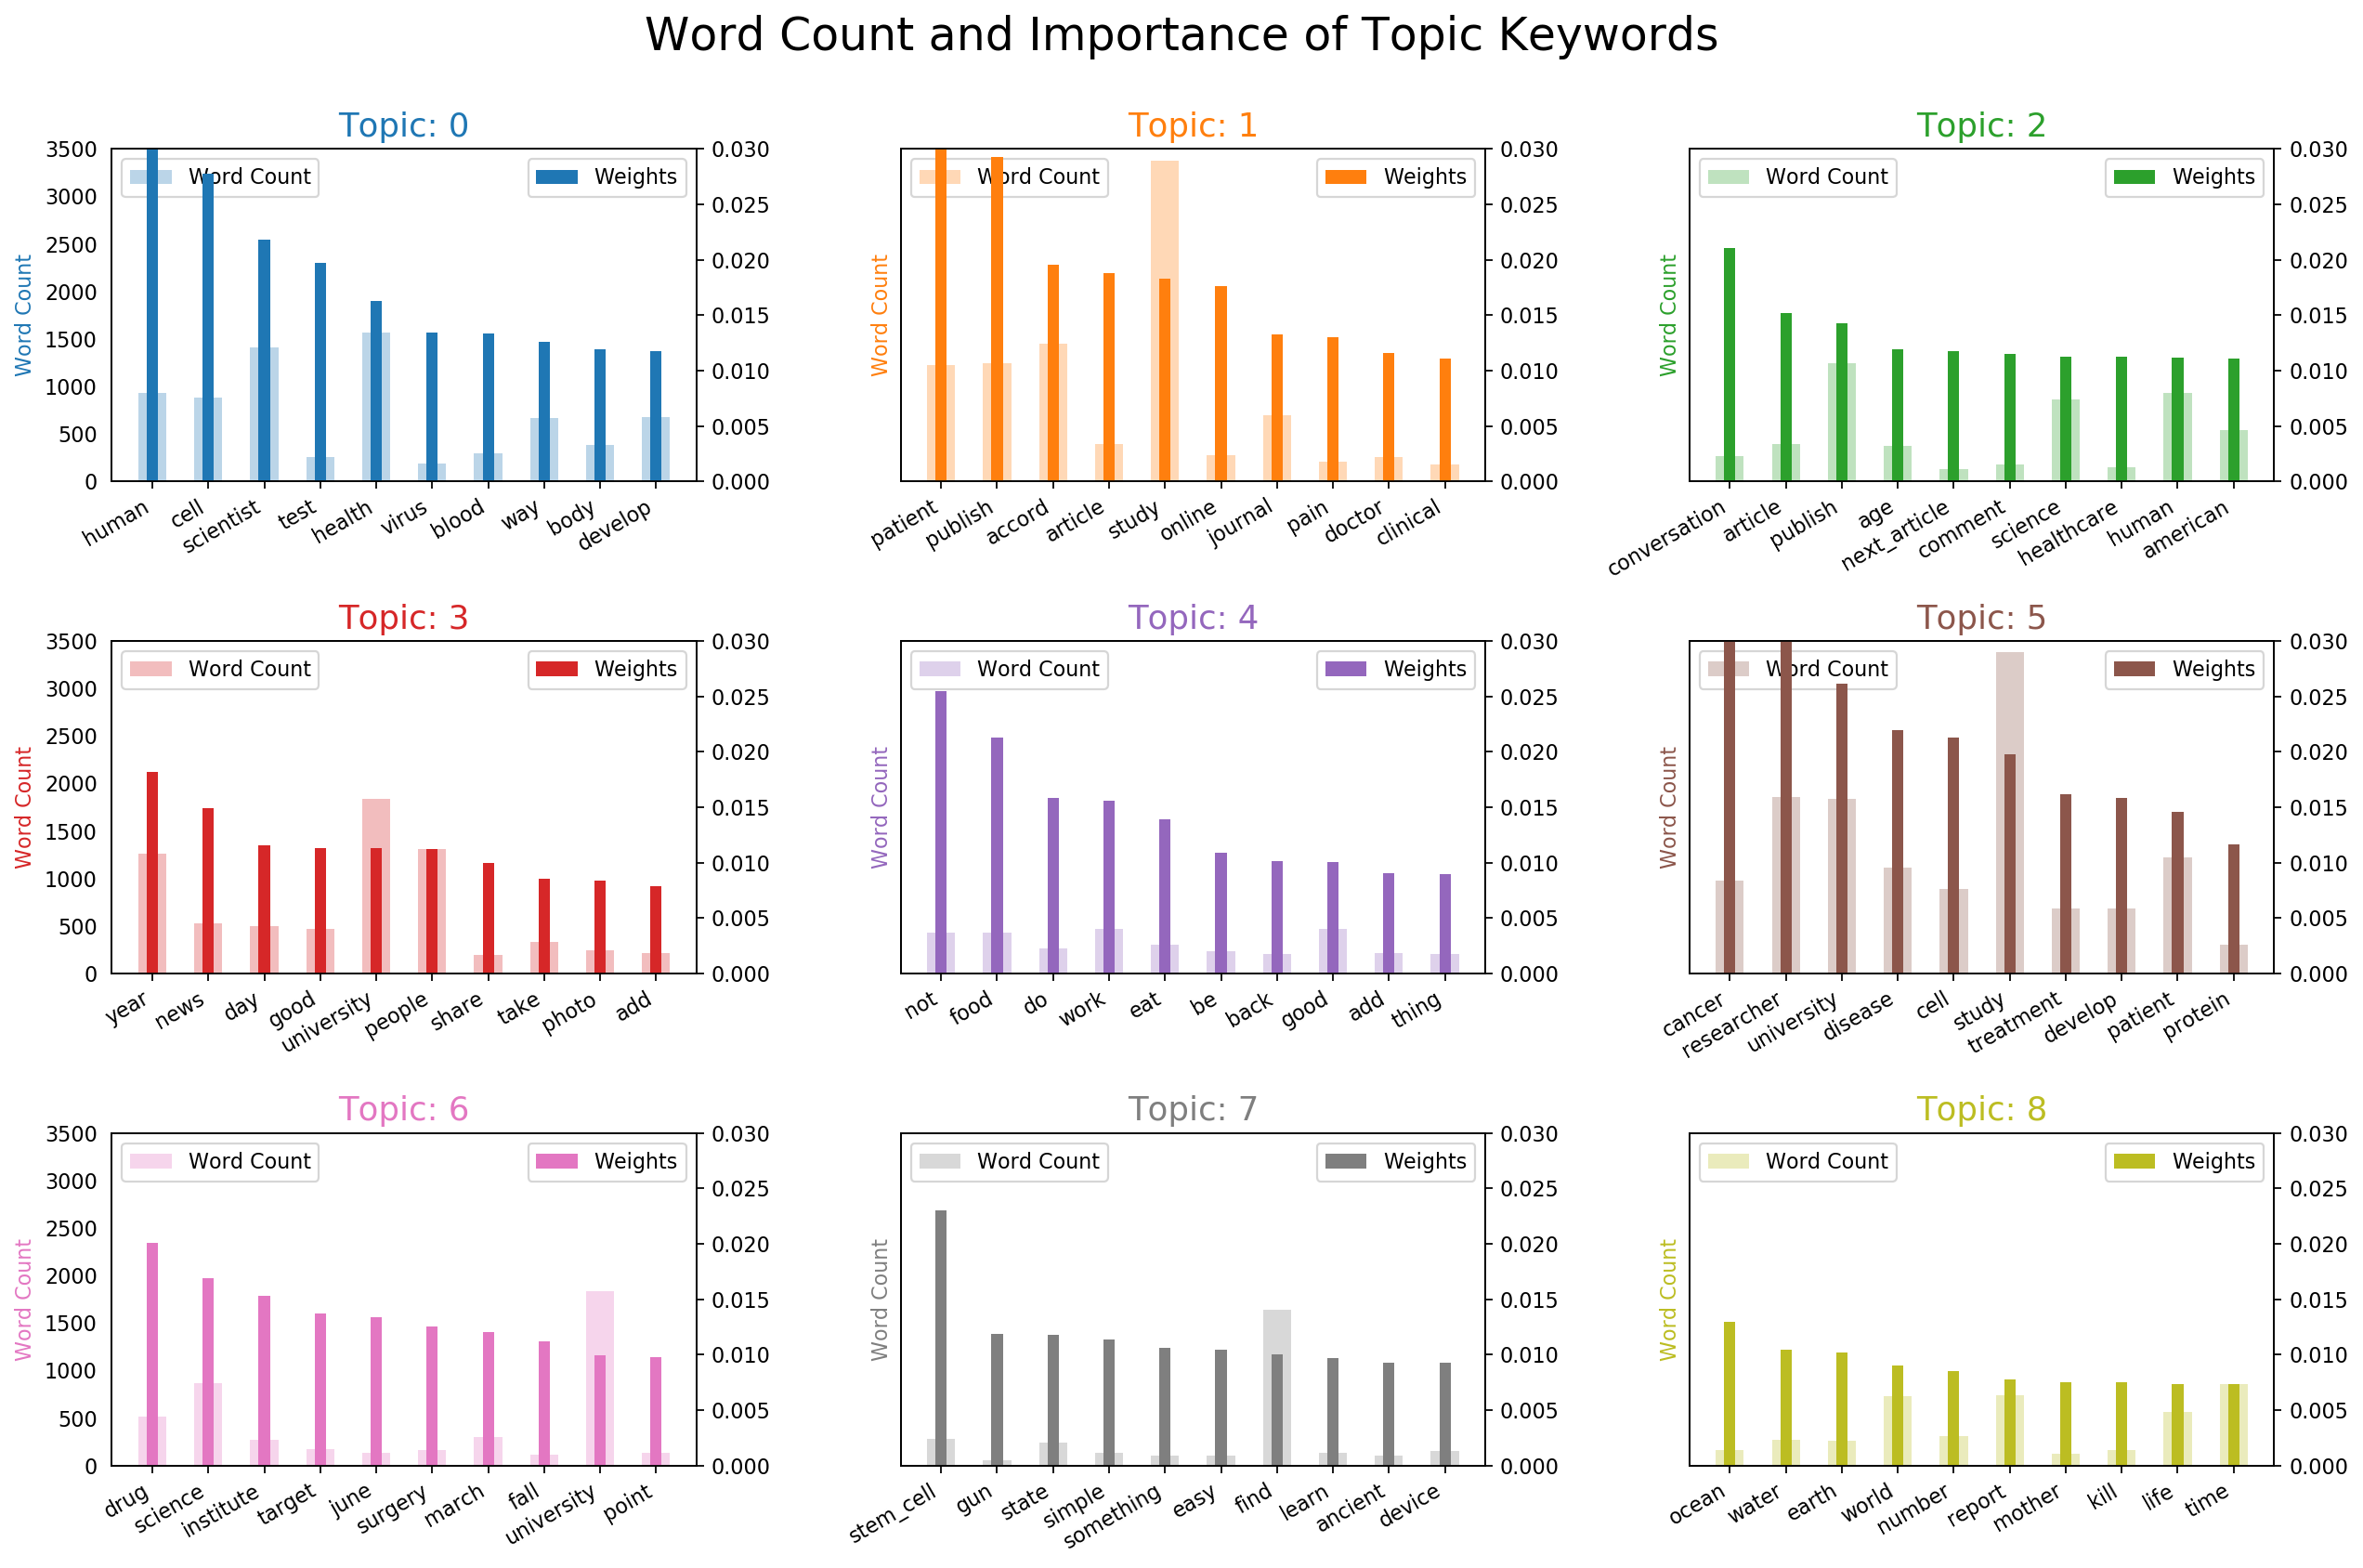

In [67]:
from collections import Counter
topics = lda_model.show_topics(num_topics=14, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_w = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_w.loc[df_w.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_w.loc[df_w.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_w.loc[df_w.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [69]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 14
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13220 samples in 0.009s...
[t-SNE] Computed neighbors for 13220 samples in 0.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13220
[t-SNE] Computed conditional probabilities for sample 2000 / 13220
[t-SNE] Computed conditional probabilities for sample 3000 / 13220
[t-SNE] Computed conditional probabilities for sample 4000 / 13220
[t-SNE] Computed conditional probabilities for sample 5000 / 13220
[t-SNE] Computed conditional probabilities for sample 6000 / 13220
[t-SNE] Computed conditional probabilities for sample 7000 / 13220
[t-SNE] Computed conditional probabilities for sample 8000 / 13220
[t-SNE] Computed conditional probabilities for sample 9000 / 13220
[t-SNE] Computed conditional probabilities for sample 10000 / 13220
[t-SNE] Computed conditional probabilities for sample 11000 / 13220
[t-SNE] Computed conditional probabilities for sample 12000 / 13220
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [83]:
df_vis = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics) for topics_document in topics])\
  .reset_index(drop=True).fillna(0)

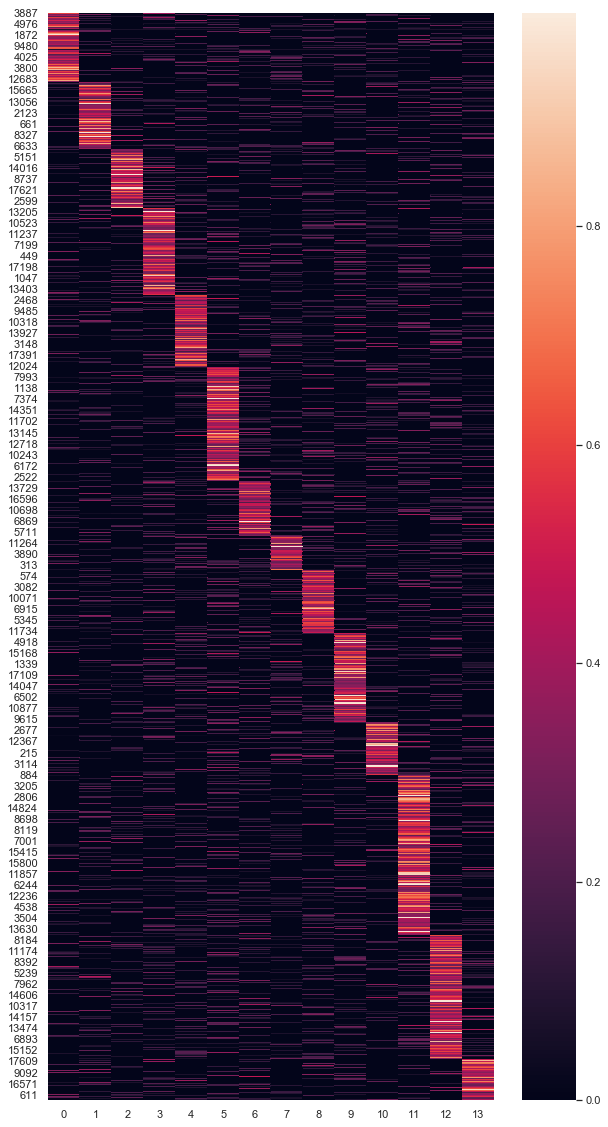

In [85]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(df_vis.loc[df_vis.idxmax(axis=1).sort_values().index])

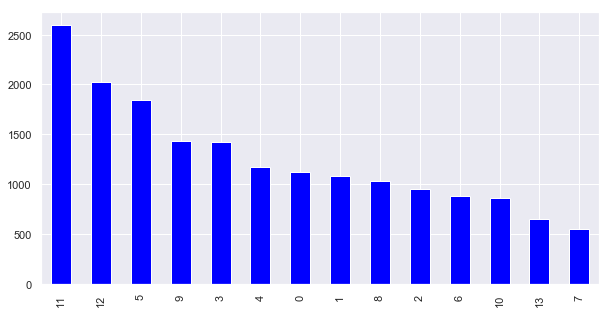

In [86]:
sns.set(rc={'figure.figsize':(10,5)})
df_vis.idxmax(axis=1).value_counts().plot.bar(color='blue')

In [87]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\srika\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.188466  0.082633       1        1  11.823061
12    -0.142407  0.078962       2        1  10.262690
5     -0.179265 -0.089318       3        1   9.684055
3      0.146820  0.126133       4        1   7.842348
9      0.161340 -0.022680       5        1   7.255976
4      0.184834  0.112860       6        1   6.781313
1     -0.211422  0.056945       7        1   6.521466
8      0.029297  0.090748       8        1   6.365811
6     -0.023396 -0.088019       9        1   6.354144
0     -0.007956 -0.122899      10        1   6.034214
10    -0.094737 -0.053426      11        1   5.850785
2     -0.002119  0.083504      12        1   5.751958
7      0.116111 -0.320590      13        1   4.738590
13     0.211366  0.065147      14        1   4.733591, topic_info=     Category         Freq           Term        Total  loglift  logprob
644   Default  1301.000000         cancer  1301.000000  30.0000  30.0000
663   Default  1404.000000           risk  1404.000000  29.0000  29.0000
142   Default  4243.000000          study  4243.000000  28.0000  28.0000
90    Default  1610.000000        patient  1610.000000  27.0000  27.0000
1439  Default  1054.000000           cell  1054.000000  26.0000  26.0000
246   Default  1536.000000        publish  1536.000000  25.0000  25.0000
75    Default  1045.000000          human  1045.000000  24.0000  24.0000
194   Default  1742.000000      scientist  1742.000000  23.0000  23.0000
688   Default  1484.000000        disease  1484.000000  22.0000  22.0000
544   Default  1974.000000         health  1974.000000  21.0000  21.0000
230   Default   486.000000            not   486.000000  20.0000  20.0000
920   Default   668.000000        article   668.000000  19.0000  19.0000
979   Default  1056.000000      treatment  1056.000000  18.0000  18.0000
117   Default   595.000000           food   595.000000  17.0000  17.0000
0     Default  1822.000000         accord  1822.000000  16.0000  16.0000
1252  Default   510.000000          death   510.000000  15.0000  15.0000
1067  Default   715.000000           drug   715.000000  14.0000  14.0000
408   Default  2152.000000     university  2152.000000  13.0000  13.0000
8     Default   996.000000           high   996.000000  12.0000  12.0000
441   Default   387.000000   conversation   387.000000  11.0000  11.0000
709   Default   376.000000           test   376.000000  10.0000  10.0000
545   Default   763.000000       increase   763.000000   9.0000   9.0000
2504  Default   303.000000      stem_cell   303.000000   8.0000   8.0000
159   Default   797.000000        develop   797.000000   7.0000   7.0000
2404  Default   517.000000          heart   517.000000   6.0000   6.0000
546   Default   887.000000        journal   887.000000   5.0000   5.0000
911   Default   619.000000       medicine   619.000000   4.0000   4.0000
1943  Default   343.000000         online   343.000000   3.0000   3.0000
514   Default  1028.000000          first  1028.000000   2.0000   2.0000
501   Default   885.000000          woman   885.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2889  Topic14   106.257248           full   108.364746   3.0308  -4.8197
633   Topic14    48.171753            son    48.640457   3.0408  -5.6108
241   Topic14   214.454346           hour   236.749023   2.9516  -4.1175
837   Topic14   120.489403     zika_virus   135.440781   2.9335  -4.6940
2270  Topic14   122.096191          night   138.778427   2.9224  -4.6807
228   Topic14    59.818489            fly    62.395599   3.0083  -5.3942
2006  Topic14    71.357986          speak    78.075089   2.9605  -5.2178
574   Topic14   101.175621       practice   121.756577   2.8653  -4.8687
1     Topic14   108.956772        biology   135.628525   2.8315  -4.7946
1184  Topic14   118.506676            sit   162.267609   2.7362  -4.7106
3474  Topic14    83.445221 

# using TF -IDF

In [90]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dictionary_tfidf = gensim.corpora.Dictionary(data_lemmatized)
type(dictionary_tfidf)

gensim.corpora.dictionary.Dictionary

In [91]:
dictionary_tfidf[1]

'biology'

In [92]:
bow_corpus = [dictionary_tfidf.doc2bow(doc) for doc in data_lemmatized]
bow_corpus[4310]

[(3, 1),
 (20, 1),
 (74, 1),
 (123, 1),
 (174, 1),
 (377, 1),
 (581, 1),
 (1384, 1),
 (1496, 1),
 (1718, 1),
 (1793, 1),
 (2513, 1),
 (2649, 1),
 (4300, 1),
 (4915, 1),
 (9237, 1),
 (9238, 1)]

In [94]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.09386025463211801),
 (1, 0.16791606821031146),
 (2, 0.2876083817659003),
 (3, 0.17191559742880982),
 (4, 0.2552921427732999),
 (5, 0.36529616085034156),
 (6, 0.21840345190365237),
 (7, 0.33940023448886114),
 (8, 0.11737769827222043),
 (9, 0.1877023900120858),
 (10, 0.15641730914911395),
 (11, 0.3299973801950783),
 (12, 0.22842577419987964),
 (13, 0.2970589123373808),
 (14, 0.1914245533519597),
 (15, 0.24216394423719284),
 (16, 0.26670117815671784)]


In [95]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=14, id2word=dictionary_tfidf, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"study" + 0.002*"virus" + 0.002*"cell" + 0.002*"disease" + 0.002*"find" + 0.002*"people" + 0.002*"researcher" + 0.002*"risk" + 0.002*"human" + 0.002*"healthday"
Topic: 1 Word: 0.005*"site" + 0.005*"view" + 0.005*"mobile" + 0.004*"important" + 0.004*"editor" + 0.004*"consider" + 0.004*"healthday" + 0.003*"development" + 0.003*"cancer" + 0.003*"study"
Topic: 2 Word: 0.003*"study" + 0.003*"risk" + 0.003*"heart" + 0.002*"disease" + 0.002*"accord" + 0.002*"find" + 0.002*"eat" + 0.002*"increase" + 0.002*"breakfast" + 0.002*"health"
Topic: 3 Word: 0.003*"study" + 0.002*"research" + 0.002*"people" + 0.002*"year" + 0.002*"researcher" + 0.002*"accord" + 0.002*"publish" + 0.002*"university" + 0.002*"health" + 0.002*"scientist"
Topic: 4 Word: 0.003*"article" + 0.003*"health" + 0.003*"year" + 0.003*"study" + 0.003*"people" + 0.002*"publish" + 0.002*"find" + 0.002*"cancer" + 0.002*"way" + 0.002*"research"
Topic: 5 Word: 0.003*"study" + 0.002*"researcher" + 0.002*"university" + 0

In [165]:
data_words_trigrams = make_trigrams(data_words_nostops)

In [166]:
data_lemmatized_trigram = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [167]:
# Create Dictionary
id2word_trigram = corpora.Dictionary(data_lemmatized_trigram)

# Create Corpus
texts_trigram = data_lemmatized_trigram

# Term Document Frequency
corpus_trigram = [id2word_trigram.doc2bow(text) for text in texts_trigram]

# View
print(corpus_trigram[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1)]]


In [168]:
model_list_trigram, coherence_values_trigram = compute_coherence_values(dictionary=id2word_trigram, corpus=corpus_trigram, texts=data_lemmatized_trigram, start=2, limit=40, step=6)

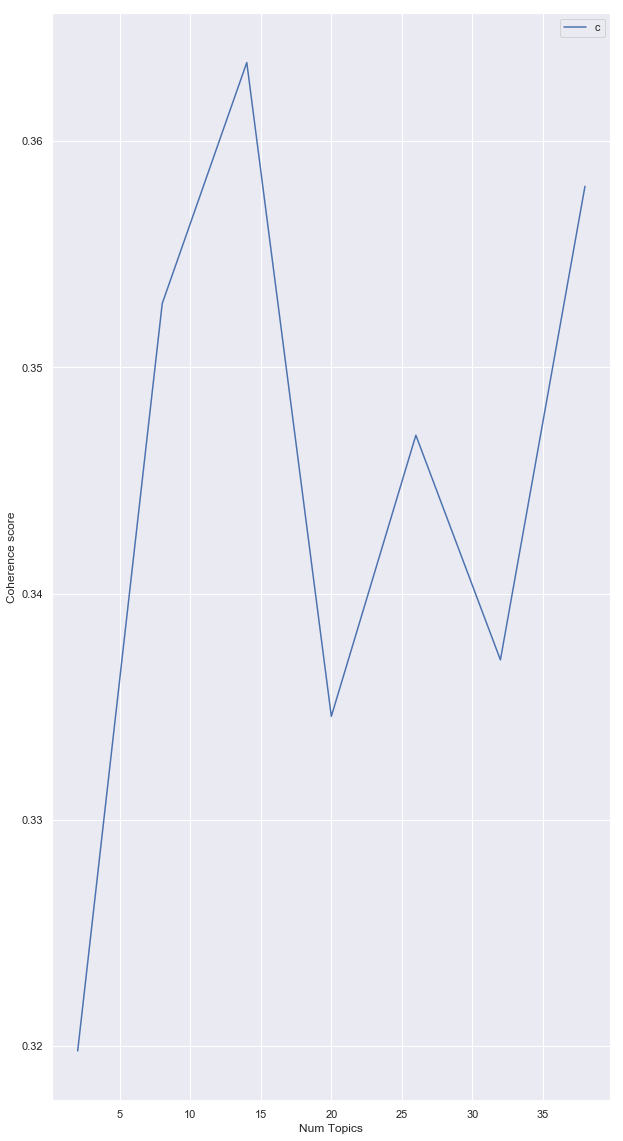

In [169]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_trigram)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [560]:
np.random.seed(123456)
num_topics = 14
%time lda_model_trigram = models.LdaModel(corpus_trigram, num_topics=num_topics, id2word=id2word_trigram, passes=4, alpha=[0.01]*num_topics, eta=[0.01]*len(id2word.keys()))

C:\Users\srika\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Wall time: 22.7 s


In [569]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"publish" + 0.018*"science" + 0.017*"research" + 0.015*"today" + '
  '0.013*"journal" + 0.012*"paper" + 0.011*"pain" + 0.011*"january" + '
  '0.011*"university" + 0.010*"nature"'),
 (1,
  '0.016*"disease" + 0.015*"health" + 0.015*"people" + 0.013*"death" + '
  '0.012*"percent" + 0.012*"sleep" + 0.012*"still" + 0.011*"time" + '
  '0.010*"grow" + 0.010*"stem_cell"'),
 (2,
  '0.018*"scientist" + 0.016*"human" + 0.012*"water" + 0.010*"researcher" + '
  '0.010*"chemical" + 0.010*"bacteria" + 0.008*"change" + 0.008*"animal" + '
  '0.008*"find" + 0.008*"fish"'),
 (3,
  '0.025*"breast_cancer" + 0.019*"research" + 0.012*"comment" + 0.011*"datum" '
  '+ 0.011*"imagine" + 0.010*"autism" + 0.010*"use" + 0.010*"function" + '
  '0.010*"show" + 0.009*"cut"'),
 (4,
  '0.045*"cell" + 0.023*"cancer" + 0.023*"university" + 0.021*"researcher" + '
  '0.020*"scientist" + 0.018*"develop" + 0.013*"blood" + 0.012*"way" + '
  '0.011*"test" + 0.009*"decline"'),
 (5,
  '0.035*"not" + 0.028*"do" + 0.

In [568]:
# Print the Keyword in the 14 topics
pprint(lda_model_trigram.print_topics())
doc_lda_TRIG= lda_model_trigram[corpus]

[(0,
  '0.022*"publish" + 0.018*"science" + 0.017*"research" + 0.015*"today" + '
  '0.013*"journal" + 0.012*"paper" + 0.011*"pain" + 0.011*"january" + '
  '0.011*"university" + 0.010*"nature"'),
 (1,
  '0.016*"disease" + 0.015*"health" + 0.015*"people" + 0.013*"death" + '
  '0.012*"percent" + 0.012*"sleep" + 0.012*"still" + 0.011*"time" + '
  '0.010*"grow" + 0.010*"stem_cell"'),
 (2,
  '0.018*"scientist" + 0.016*"human" + 0.012*"water" + 0.010*"researcher" + '
  '0.010*"chemical" + 0.010*"bacteria" + 0.008*"change" + 0.008*"animal" + '
  '0.008*"find" + 0.008*"fish"'),
 (3,
  '0.025*"breast_cancer" + 0.019*"research" + 0.012*"comment" + 0.011*"datum" '
  '+ 0.011*"imagine" + 0.010*"autism" + 0.010*"use" + 0.010*"function" + '
  '0.010*"show" + 0.009*"cut"'),
 (4,
  '0.045*"cell" + 0.023*"cancer" + 0.023*"university" + 0.021*"researcher" + '
  '0.020*"scientist" + 0.018*"develop" + 0.013*"blood" + 0.012*"way" + '
  '0.011*"test" + 0.009*"decline"'),
 (5,
  '0.035*"not" + 0.028*"do" + 0.

In [471]:
type(document_topic)

pandas.core.frame.DataFrame

In [473]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weigh)

In [520]:
tp = [(t, d) for t, d in df_topic_distribution.values]
tp.sort(key = lambda x:x[0])
tp

[(0, 983),
 (1, 1218),
 (2, 1493),
 (3, 736),
 (4, 1264),
 (5, 508),
 (6, 789),
 (7, 1263),
 (8, 950),
 (9, 1641),
 (10, 2676),
 (11, 1302),
 (12, 1042),
 (13, 1776)]

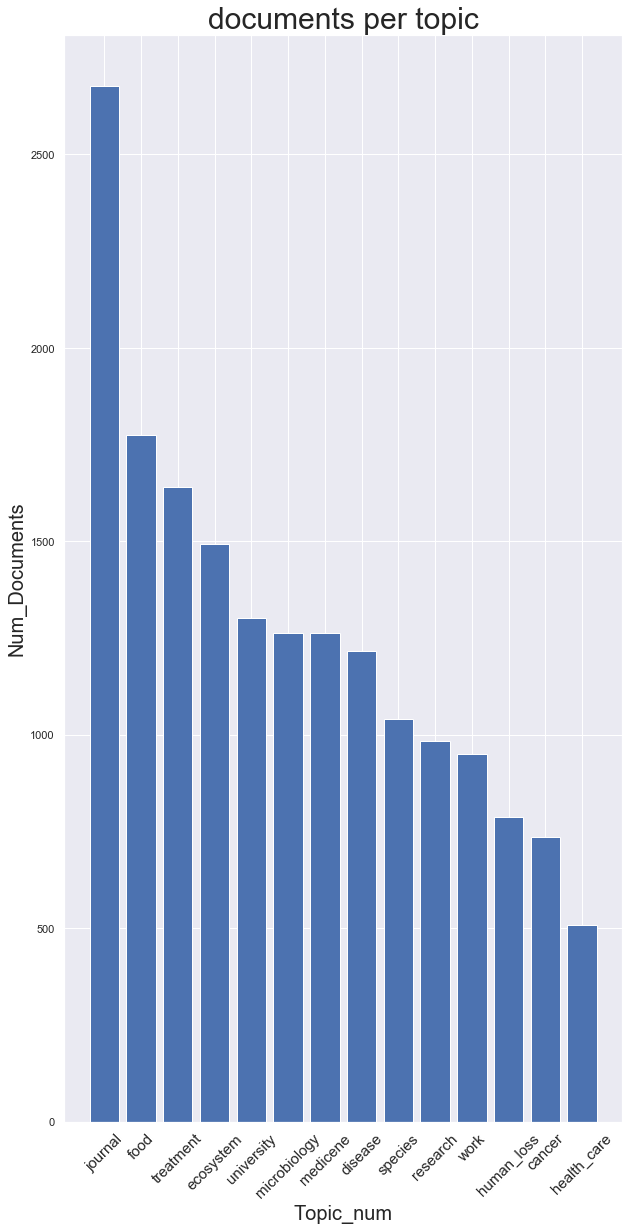

In [468]:
Topic_num = ['journal', 'food', 'treatment', 'ecosystem', 'university', 'microbiology', 'medicene', 'disease', 'species', 'research', 'work', 'human_loss', 'cancer', 'health_care']
Num_Documents = df_topic_distribution.Num_Documents.values.tolist()
plt.bar(Topic_num, Num_Documents)
plt.xlabel('Topic_num', fontsize=20)
plt.ylabel('Num_Documents', fontsize=20)
plt.xticks(Topic_num, fontsize=15, rotation=45)
plt.title('documents per topic', fontsize=30)
plt.show()

In [399]:
topics_tfidf = [lda_model_tfidf[corpus_tfidf[i]] for i in range(len(df.content.values.tolist()))]

In [400]:
topics_tfidf[0]

[(0, 0.0145266475),
 (1, 0.014526594),
 (2, 0.014526587),
 (3, 0.8111517),
 (4, 0.014526795),
 (5, 0.014526653),
 (6, 0.014526962),
 (7, 0.014526595),
 (8, 0.014528126),
 (9, 0.01452658),
 (10, 0.0145266),
 (11, 0.014526949),
 (12, 0.01452659),
 (13, 0.014526592)]

In [401]:
document_topic_tfidf = pd.concat([topics_document_to_dataframe(topics_document, num_topics) for topics_document in topics_tfidf])\
  .reset_index(drop=True).fillna(0)

In [402]:
document_topic_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.014527,0.014527,0.014527,0.811152,0.014527,0.014527,0.014527,0.014527,0.014528,0.014527,0.014527,0.014527,0.014527,0.014527
1,0.018207,0.018207,0.018207,0.018207,0.018207,0.763310,0.018207,0.018207,0.018207,0.018207,0.018207,0.018207,0.018207,0.018207
2,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.821967,0.013695
3,0.013818,0.013819,0.013818,0.013819,0.013819,0.013820,0.013819,0.013819,0.013819,0.013819,0.013818,0.013819,0.013819,0.820357
4,0.014176,0.014176,0.014176,0.014176,0.014176,0.014176,0.593516,0.014176,0.014176,0.014176,0.014176,0.014513,0.236036,0.014176


In [403]:
dominant_topic_tfidf = np.argmax(document_topic_tfidf.values, axis=1)
document_topic_tfidf['dominant_topic'] = dominant_topic_tfidf

In [404]:
document_topic_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,dominant_topic
0,0.014527,0.014527,0.014527,0.811152,0.014527,0.014527,0.014527,0.014527,0.014528,0.014527,0.014527,0.014527,0.014527,0.014527,3
1,0.018207,0.018207,0.018207,0.018207,0.018207,0.763310,0.018207,0.018207,0.018207,0.018207,0.018207,0.018207,0.018207,0.018207,5
2,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.013695,0.821967,0.013695,12
3,0.013818,0.013819,0.013818,0.013819,0.013819,0.013820,0.013819,0.013819,0.013819,0.013819,0.013818,0.013819,0.013819,0.820357,13
4,0.014176,0.014176,0.014176,0.014176,0.014176,0.014176,0.593516,0.014176,0.014176,0.014176,0.014176,0.014513,0.236036,0.014176,6


In [405]:
type(document_topic_tfidf)

pandas.core.frame.DataFrame

In [406]:
df_topic_distribution_tfidf = document_topic_tfidf['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution_tfidf.columns = ['Topic_Num', 'Num_Documents']
df_topic_distribution_tfidf

,Topic_Num,Num_Documents
0,8,2144
1,10,1687
2,3,1605
3,6,1327
4,4,1325
5,11,1275
6,7,1246
7,5,1210
8,9,1189
9,1,1130


In [126]:
type(df_topic_distribution)

pandas.core.frame.DataFrame

In [131]:
x = df_topic_distribution.Topic_Num.tolist()
x

[2678, 1776, 1635, 1497, 1298, 1271, 1264, 1216, 1042, 977, 944, 789, 743, 512]

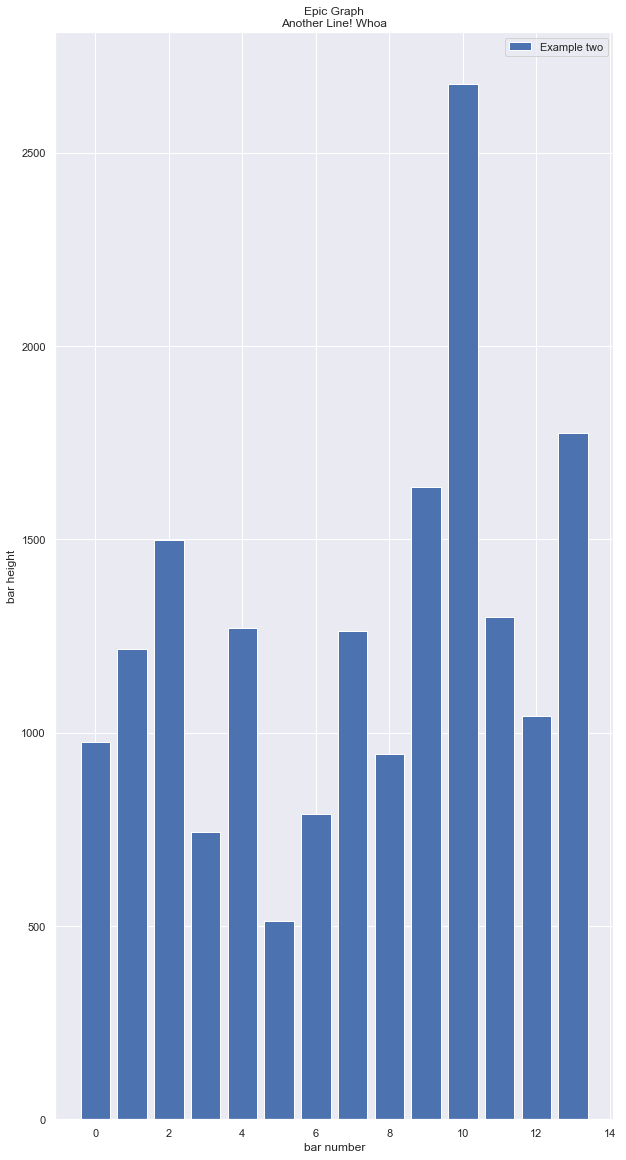

In [325]:
df_2 = pd.DataFrame({'Topics':df_topic_distribution.Topic_Num.tolist(), 'No_Documents':df_topic_distribution.Num_Documents.tolist()})
plt.bar(df_2.Topics.values, df_2.No_Documents.values, label="Example two", color='b')
plt.legend()
plt.xlabel('')
plt.ylabel('')

plt.title(')

plt.show()

In [566]:
c1=mycolors[1]
c1

'#ff7f0e'

df_vis.set_axis(["Topic "+ str(i) for i in range(14) ], axis='columns', inplace=True)
df_vis.head()

In [490]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [494]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized_g = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_g[:2])

['teach creationism public school have consistently be rule federal court accord national survey more public high school biology teacher continue flourish nation', 'collection paper explore how why public bend scientific finding fit belief']


In [496]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized_g)

In [497]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.33996412304860724 %


In [499]:
# Build LDA Model
lda_model_sck = LatentDirichletAllocation(n_topics=14,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model_sck.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=14, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [500]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [501]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -688682.548626852
Model Perplexity:  2038.408258995759


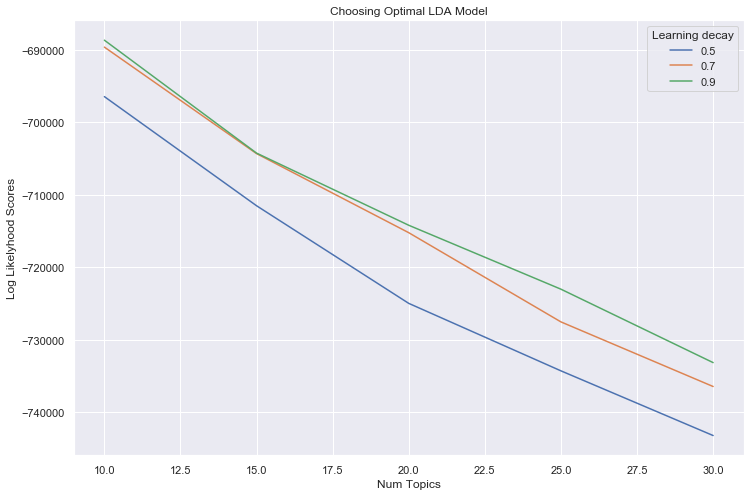

In [502]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [506]:
lda_output = best_lda_model.transform(data_vectorized)
print(best_lda_model.n_topics)

None


In [508]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(10)]

# index names
#docnames = ["Doc" + str(i) for i in range(len(df.content.values.tolist()))]

# Make the pandas dataframe
df_document_topic_cv = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic_cv.values, axis=1)
df_document_topic_cv['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic_cv.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.01,0.84,0.11,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
1,0.01,0.79,0.01,0.01,0.12,0.01,0.01,0.01,0.01,0.01,1
2,0.01,0.95,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
3,0.01,0.01,0.01,0.01,0.01,0.01,0.92,0.01,0.01,0.01,6
4,0.79,0.01,0.15,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0
5,0.85,0.01,0.01,0.09,0.01,0.01,0.01,0.01,0.01,0.01,0
6,0.01,0.01,0.01,0.93,0.01,0.01,0.01,0.01,0.01,0.01,3
7,0.01,0.01,0.01,0.3,0.01,0.63,0.01,0.01,0.01,0.01,5
8,0.01,0.01,0.95,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2
9,0.01,0.12,0.51,0.01,0.01,0.01,0.01,0.12,0.01,0.19,2


set()